In [123]:
# This injects fake planets by (and without using PynPoint)
# 1.  Determining a mask over the host star PSF where nonlinearity/saturation may be an issue
# 2.  Fitting a first PCA basis to the masked host star PSF (using UN-saturated frames as the basis set)
# 3.  Reconstructing the ideal, unsaturated host star PSF for making fake planets
# 4.  Injecting it with a variety of amplitudes/angles around the host star
# 5.  Fitting a second PCA basis to the NON-masked host star PSF (using saturated frames as the basis set)
# 6.  Reconstructing the saturated host star PSF for host star subtraction
# 7.  Subtracting the host star PSF
# 8.  Doing ADI

# created 2019 Jan. 11 by E.S.

## SECTION TO INITIALIZE

In [1]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
import time
from matplotlib.colors import LogNorm
import pandas as pd
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion, PolygonPixelRegion

ImportError: cannot import name 'RandomizedPCA'

In [2]:
import os
from astropy.io import fits
from astropy.modeling import models, fitting

In [3]:
# stem 

stem_base = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/')
stem_retrieve = (stem_base+'05_centered/') # use frames which have already been centered and are well-behaved, for now
stem_place = (stem_base+'testing/')

In [ ]:
# First part reads in a stack of images from which
# 1. host star has been subtracted
# 2. images have been de-rotated
# 3. a fake planet may or may not be present

# So the task here is to 
# 1. median the stack
# 2. convolve the median to smooth it

# ... and, if there is a 

# -> /fake_planet flag: (i.e., we're determining sensitivity)
# 1. given the fake planet location, find its amplitude
# 2. find the stdev of the noise ring 
# 3. count number of other false positives of amplitude >=Nsigma
# 4. calculate false positive fraction (FPF)

# -> /true_data flag: (i.e., we're looking for true candidates)
# 1. do a 2d cross-correlation of the ring with the unsaturated,
#     reconstructed host star PSF (see scipy.signal.correlate2d)
# 2. find where the correlation is maximum
# 3. find the max around that location in the image
# 4. mask that location and find the stdev of the rest of the ring
# 5. if S/N >= Nsigma, flag it!

In [ ]:
## ## GENERATE LIST OF FILES IN THE FAKE PLANET / HOST SUBTRACTED DIRECTORY

In [2]:
# Smooth the image, so that the rms calculation will consider PSF-to-PSF variations
# This is the Gaussian smoothing option
'''
sig_y = 9.46 # lambda/D, in pix
sig_x = 3.44 # lambda/B, in pix

smoothed_w_fake_planet = scipy.ndimage.filters.gaussian_filter(star_subted, 
                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), 
                                                 order=0, 
                                                 output=None, 
                                                 mode='reflect', 
                                                 cval=0.0, 
                                                 truncate=4.0)

smoothed_wo_fake_planet = scipy.ndimage.filters.gaussian_filter(star_subted_wo_fake_planet, 
                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), 
                                                 order=0, 
                                                 output=None, 
                                                 mode='reflect', 
                                                 cval=0.0, 
                                                 truncate=4.0)
'''

"\nsig_y = 9.46 # lambda/D, in pix\nsig_x = 3.44 # lambda/B, in pix\n\nsmoothed_w_fake_planet = scipy.ndimage.filters.gaussian_filter(star_subted, \n                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), \n                                                 order=0, \n                                                 output=None, \n                                                 mode='reflect', \n                                                 cval=0.0, \n                                                 truncate=4.0)\n\nsmoothed_wo_fake_planet = scipy.ndimage.filters.gaussian_filter(star_subted_wo_fake_planet, \n                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), \n                                                 order=0, \n                                                 output=None, \n                                                 mode='reflect', \n                                                 cval=0.0, \n   

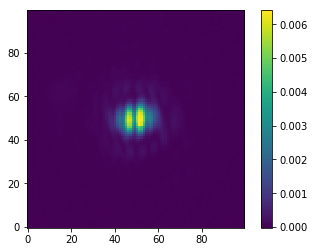

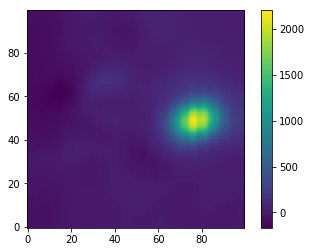

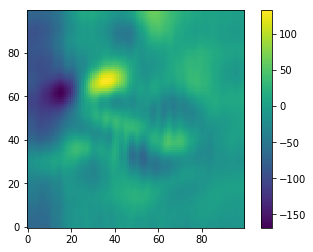

In [39]:
# Smooth the image, so that the rms calculation will consider PSF-to-PSF variations
# This is the LBT PSF smoothing option

weights = np.divide(sciImg,np.sum(sciImg)) # normalize the host star PSF

smoothed2 = ndimage.filters.convolve(star_subted, 
                                    weights, 
                                    output=None, 
                                    mode='reflect', 
                                    cval=0.0, 
                                    origin=0) 

smoothed_wo_fake_planet2 = ndimage.filters.convolve(star_subted_wo_fake_planet, 
                                                   weights, 
                                                   output=None, 
                                                   mode='reflect', 
                                                   cval=0.0, 
                                                   origin=0)

In [ ]:
plt.imshow(weights, origin="lower")
plt.colorbar()
plt.show()

plt.imshow(smoothed2, origin="lower")
plt.colorbar()
plt.show()

plt.imshow(smoothed_wo_fake_planet2, origin="lower")
plt.colorbar()
plt.show()

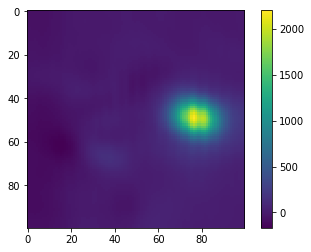

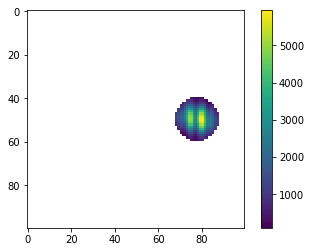

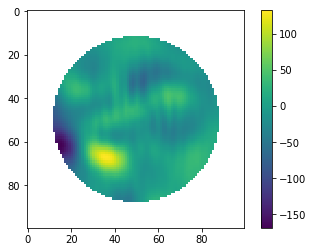

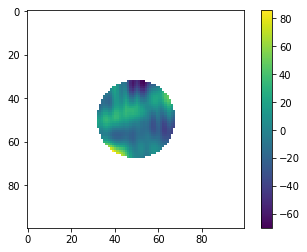

155.00140445054774


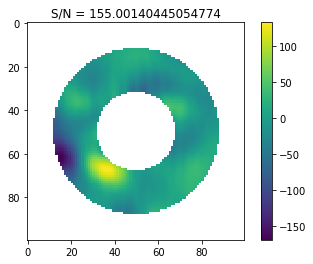

In [44]:
# Determine signal level in fake planet PSF

# define region where fake planet is supposed to be: a circle near (y,x) of injection

circRad = 10 # pixels in FFT space

# N.b. for a 100x100 image, the physical center is at Python coordinate (49.5,49.5)
# i.e., in between pixels 49 and 50 in both dimensions (Python convention),
# or at coordinate (50.5,50.5) in DS9 convention
## ## check this by displacing, flipping, and subtracting to detect asymmetry
x_cen = 0.5*np.shape(smoothed)[0]-0.5
y_cen = 0.5*np.shape(smoothed)[1]-0.5

circle_fake_psf_premask = CirclePixelRegion(
    center=PixCoord(x=x_cen+experiment_vector["x_pix_coord"][pos_num],
                    y=y_cen+experiment_vector["y_pix_coord"][pos_num]),
    radius=circRad
)

fake_psf_outer_edge_rad = experiment_vector["x_pix_coord"][pos_num] + circRad
fake_psf_inner_edge_rad = experiment_vector["x_pix_coord"][pos_num] - circRad

annulus_noise_premask_outer = CirclePixelRegion(
    center=PixCoord(x=x_cen,y=y_cen),
    radius=fake_psf_outer_edge_rad
)

annulus_noise_premask_inner = CirclePixelRegion(
    center=PixCoord(x=x_cen,y=y_cen),
    radius=fake_psf_inner_edge_rad
)


# make the mask
mask_circ = circle_fake_psf_premask.to_mask()
mask_annulus_inner = annulus_noise_premask_inner.to_mask()
mask_annulus_outer = annulus_noise_premask_outer.to_mask()

sciImg1 = np.copy(smoothed2)
    
plt.imshow(sciImg1)
plt.colorbar()
plt.show()
    
# display area around PSF to find amplitude of fake planet
sciImg1.fill(np.nan) # initialize arrays of nans
mask_circ.data[mask_circ.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
sciImg1[mask_circ.bbox.slices] = mask_circ.data  # place the mask cutout (consisting only of 1s) onto the array of nans
sciImgAroundPSF = np.multiply(sciImg1,smoothed) # 'transmit' the original science image through the mask
plt.imshow(sciImgAroundPSF)
plt.colorbar()
plt.show()
#plt.savefig('test_psf.png')

# display area in annulus with radius of that of the planet, but without planet itself

sciImg1.fill(np.nan) # initialize arrays of nans
mask_annulus_outer.data[mask_annulus_outer.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
sciImg1[mask_annulus_outer.bbox.slices] = mask_annulus_outer.data  # place the mask cutout (consisting only of 1s) onto the array of nans
sciImgOuter = np.multiply(sciImg1,smoothed_wo_fake_planet2) # 'transmit' the original science image through the mask

plt.imshow(sciImgOuter)
plt.colorbar()
plt.show()

sciImg1.fill(np.nan) # initialize arrays of nans
mask_annulus_inner.data[mask_annulus_inner.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
sciImg1[mask_annulus_inner.bbox.slices] = mask_annulus_inner.data  # place the mask cutout (consisting only of 1s) onto the array of nans
sciImgInner = np.multiply(sciImg1,smoothed_wo_fake_planet2) # 'transmit' the original science image through the mask

plt.imshow(sciImgInner)
plt.colorbar()
plt.show()


sciImgInner_zeros = np.nan_to_num(sciImgInner)
sciImgOuter_zeros = np.nan_to_num(sciImgOuter)
sciImgAroundPSF_zeros = np.nan_to_num(sciImgAroundPSF)


img8 = np.subtract(sciImgOuter_zeros,sciImgInner_zeros)
img8[img8 == 0] = np.nan

signal1 = np.subtract(np.nanmax(sciImgAroundPSF),np.nanstd(img8))
noise1 = np.nanstd(img8)

print(np.divide(signal1,noise1))

plt.imshow(img8)
plt.title("S/N = " + str(np.divide(signal1,noise1)))
plt.colorbar()
#plt.show()

#plt.imshow(np.subtract(sciImgOuter,sciImgInner))
#plt.colorbar()
#plt.show()

#plt.savefig('test.png')
#plt.show()

lm_180507_009000_nPCA164.fits


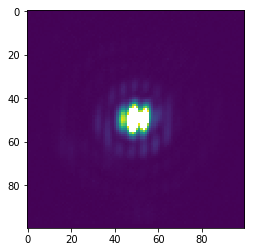

In [42]:
framenum = 9000

#### BELOW FOR FOR LOOP
# fit 2D Gaussian
img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
    
# if file exists
if os.path.isfile(stem_retrieve+img_string):
        
    # read in image
    sciImg, header = fits.getdata(stem_retrieve+img_string,0,header=True)
        
    print(img_string)
        
    sciImg_masked = np.copy(sciImg)
    mask_threshold = 35000 # pixel counts above this will be masked (refine this later based on linearity data)
    sciImg_masked[sciImg_masked > mask_threshold] = np.nan
        
    #plt.hist(np.ravel(sciImg), bins=1000)
    #plt.xlim([0,5000])
        
    plt.imshow(sciImg_masked)
    plt.show()
    
    # find the PCA spectrum 
    